# Installing dependencies

In [1]:
!pip install node2vec
!pip install pycountry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 39.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
mlxte

# Imports

In [2]:
import os
import random

#Data
import numpy as np
import pandas as pd
import re
import json

#Graphing
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tqdm import tqdm

# Models
from kaggle_secrets import UserSecretsClient
from openai import AzureOpenAI
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from node2vec import Node2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F
import umap

#Metrics
import pycountry
from sklearn.metrics.pairwise import cosine_similarity

#Transformations
from sklearn.preprocessing import normalize
import networkx as nx
from itertools import combinations
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
from collections import Counter
import ast

2025-06-20 07:14:25.960989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750403666.226021      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750403666.310487      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Policy Embeddings
In this notebook, I vectorized each nation's political stance by:
- cleaning text
- embedding country speeches with semantic segmentation and averaging
- graph based knowledge embedding utilzied country information such as: political bloc, voting record
- combining vectors

# Cleaning Text

In [3]:
# Function for cleaning data

def clean_text(text: str) -> str:
    """Clean text by removing country names while preserving stopwords"""
    print("Cleaning text")
    country_names = [
        "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", 
        "Antigua", "Argentina", "Armenia", "Australia", "Austria",
        "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados",
        "Belarus", "Belgium", "Belize", "Benin", "Bhutan",
        "Bolivia", "Bosnia", "Botswana", "Brazil", "Brunei",
        "Bulgaria", "Burkina", "Burundi", "Cambodia", "Cameroon",
        "Canada", "Cape Verde", "Central African Republic", "Chad", "Chile",
        "China", "Colombia", "Comoros", "Congo", "Costa Rica",
        "Croatia", "Cuba", "Cyprus", "Czech Republic", "Denmark",
        "Djibouti", "Dominica", "Dominican Republic", "Ecuador", "Egypt",
        "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini",
        "Ethiopia", "Fiji", "Finland", "France", "Gabon",
        "Gambia", "Georgia", "Germany", "Ghana", "Greece",
        "Grenada", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana",
        "Haiti", "Honduras", "Hungary", "Iceland", "India",
        "Indonesia", "Iran", "Iraq", "Ireland", "Israel",
        "Italy", "Ivory Coast", "Jamaica", "Japan", "Jordan",
        "Kazakhstan", "Kenya", "Kiribati", "Korea", "Kosovo",
        "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon",
        "Lesotho", "Liberia", "Libya", "Liechtenstein", "Lithuania",
        "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives",
        "Mali", "Malta", "Marshall Islands", "Mauritania", "Mauritius",
        "Mexico", "Micronesia", "Moldova", "Monaco", "Mongolia",
        "Montenegro", "Morocco", "Mozambique", "Myanmar", "Namibia",
        "Nauru", "Nepal", "Netherlands", "New Zealand", "Nicaragua",
        "Niger", "Nigeria", "North Korea", "North Macedonia", "Norway",
        "Oman", "Pakistan", "Palau", "Panama", "Papua New Guinea",
        "Paraguay", "Peru", "Philippines", "Poland", "Portugal",
        "Qatar", "Romania", "Russia", "Rwanda", "Saint Kitts",
        "Saint Lucia", "Saint Vincent", "Samoa", "San Marino", "Sao Tome",
        "Saudi Arabia", "Senegal", "Serbia", "Seychelles", "Sierra Leone",
        "Singapore", "Slovakia", "Slovenia", "Solomon Islands", "Somalia",
        "South Africa", "South Korea", "South Sudan", "Spain", "Sri Lanka",
        "Sudan", "Suriname", "Sweden", "Switzerland", "Syria",
        "Taiwan", "Tajikistan", "Tanzania", "Thailand", "Timor-Leste",
        "Togo", "Tonga", "Trinidad", "Tunisia", "Turkey",
        "Turkmenistan", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates",
        "United Kingdom", "United States", "Uruguay", "Uzbekistan", "Vanuatu",
        "Vatican City", "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe"
    ]
    
    country_names += [
        "USA", "UK", "UAE", "PRC", "DPRK", 
        "ROK", "DRC", "U.S.", "U.K.", "America",
        "Britain", "England", "Scotland", "Wales", "Northern Ireland",
        "Hong Kong", "Macau", "Palestine", "Ivory Coast", "Czechia",
        "Macedonia", "Swaziland", "Burma", "East Timor", "Vatican"
    ]
    text = re.sub(r'\b(?:the\s+)?(?:delegation\s+of\s+)?(?:representative\s+of\s+)?(' + 
                  '|'.join(country_names) + r')\b', '[COUNTRY]', text, flags=re.IGNORECASE)
    
    text = re.sub(r'[^\w\s\[\]]', ' ', text) 
    text = text.lower()

    text = ' '.join(text.split()).strip()
    
    return text[:3000]

# Semantic Segmentation using GPT 4o

In [4]:
def get_segments(text: str, max_tokens = 200) -> list[str]:
    paragraphs = [p for p in text.split('\n') if p.split()]

    num_seg = max(0, len(text.split())//max_tokens) + 3
    system =     system = f"""
    You will do semantic segmentation of the following text and output the result as a JSON string.
    Segment this diplomatic text into {num_seg} coherent policy segments.
    Each segment should focus on a single policy theme (e.g., economic policy, 
    security concerns, human rights, international cooperation).
    Preserve diplomatic context and policy coherence within each segment.
    
    Return the result as JSON with this exact format:
    {{"segments": ["segment1", "segment2", "segment3"]}}
    """
    print("Doing semantic segmentation...")
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": text}
        ],
        response_format={"type": "json_object"}
    )
    
    segments = json.loads(response.choices[0].message.content)["segments"]
    if not len(paragraphs) == 1:
        segments.append(paragraphs)
    segments.append(text)
    print(f"Generated {len(segments)} segments. ")
    return segments

In [5]:
user_secrets = UserSecretsClient()

api = user_secrets.get_secret("OPENAI_API_KEY")
client = AzureOpenAI(
    api_key=api,
    api_version="2024-11-01-preview",
    azure_endpoint="https://swedencentral.api.cognitive.microsoft.com"
)

# Ensemble Embeddings using text-embedding-3-large & bge-large-en-v1.5

In [6]:
def generate_embeddings(texts: list[str]):
    stm = SentenceTransformer('BAAI/bge-large-en-v1.5')
    embeddings = []
    for i in tqdm(texts, desc='Generating embeddings with BAAI/bge-large-en-v1.5 and text-embedding-3-large'):
        bge = stm.encode(i)
        response = client.embeddings.create(
            model="text-embedding-3-large",
            input=i
        )
        emb1 = normalize([response.data[0].embedding])[0]
        emb2 = normalize([bge])[0]
        embedding = np.concatenate([emb1, emb2])
        embeddings.append(embedding)
    
    fin_emb = []
    
    for i in range(len(embeddings)):
        fin_emb.append(list(embeddings[i]))
    return fin_emb

# Knowledge injecting using node graphs

# Generating embeddings for every country speech

In [7]:
data = pd.read_csv("/kaggle/input/un-general-debates/un-general-debates.csv")
data = data.drop(columns=['session', 'year'])

code_to_country = {country.alpha_3: country.name for country in pycountry.countries}

data['country'] = data['country'].map(code_to_country)
data.head()

,country,text
0,Maldives,﻿It is indeed a pleasure for me and the member...
1,Finland,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,Niger,"﻿\nMr. President, it is a particular pleasure ..."
3,Uruguay,﻿\nDuring the debate at the fortieth session o...
4,Zimbabwe,﻿I should like at the outset to express my del...


## Generated Embeddings:

In [8]:
df = pd.read_csv("/kaggle/input/better-speech-embeddings/country_embeddings_optimized.csv").transpose()
df2 = pd.read_csv("/kaggle/input/2-hour-speech-embedding-average-5200-speeches/my_file.csv")
df.columns = df2.columns
df.drop('Unnamed: 0', inplace=True)
df.index = range(0, 4096)

In [9]:
IGO = pd.read_csv("/kaggle/input/political-igos/Major Political IGOs Expanded.csv")
IGO["Member Countries"] = IGO["Member Countries"].apply(lambda x: str(x.split("; ")))

organizations = {IGO.iloc[i]['IGO Name'] : IGO.iloc[i]['Member Countries'] for i in range(len(IGO))}

In [10]:
# Convert stringified lists into actual lists
for k in organizations:
    if isinstance(organizations[k], str):
        organizations[k] = ast.literal_eval(organizations[k])


del organizations['United Nations (UN)']

In [11]:
voting = pd.read_csv("/kaggle/input/un-grouped-voting-data/Voting Data Groupings.csv")
voting["countries"] = voting["countries"].fillna('')
voting["countries"] = voting["countries"].apply(lambda x: x.split(";") if x else [])

votings = {voting.iloc[i]['resolution'] : voting.iloc[i]['countries'] for i in range(len(voting))}

In [12]:
edge_counter = Counter()

for org_name, members in organizations.items():
    org_weight = 10 / len(members)
    for pair in combinations(members, 2):
        edge_counter[pair] += org_weight
for members in votings.values():
    for pair in combinations(members, 2):
        edge_counter[pair] += 1

G = nx.Graph()
for (u, v), w in edge_counter.items():
    G.add_edge(u, v, weight=w)

node2vec = Node2Vec(G, dimensions=128, walk_length=40, num_walks=300, 
                    p=1, q=0.25, weight_key='weight', workers=2)

model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/202 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 150/150 [00:36<00:00,  4.09it/s]


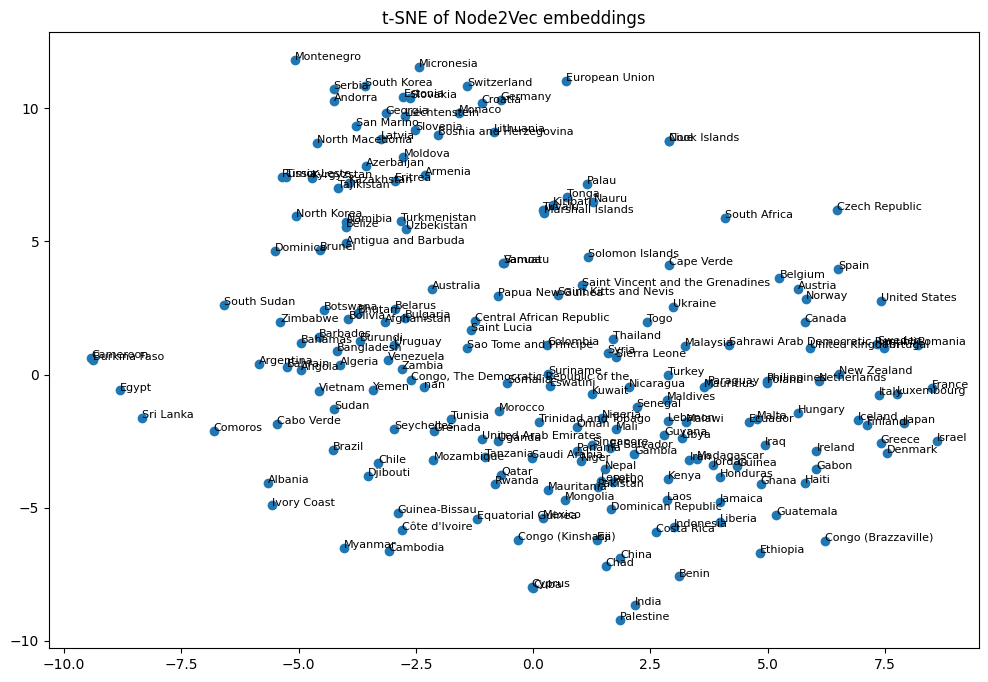

In [13]:
vecs = np.array([model.wv[country] for country in model.wv.index_to_key])
labels = model.wv.index_to_key

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(vecs)

plt.figure(figsize=(12, 8))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1])

for i, label in enumerate(labels):
    plt.annotate(label, (emb_2d[i, 0], emb_2d[i, 1]), fontsize=8)

plt.title("t-SNE of Node2Vec embeddings")
plt.show()

In [14]:
def get_organizations(country: str):
    return [igo for igo, members in organizations.items() if country in members]

In [15]:
df = df.drop(columns=['Holy See (Vatican City State)', 'Congo', 'Czechia', 'Congo, The Democratic Republic of the'])
df = df.rename(columns={'Viet Nam': 'Vietnam', 'Brunei Darussalam': 'Brunei','Iran, Islamic Republic of': 'Iran',"Lao People's Democratic Republic": 'Laos','Türkiye': 'Turkey','Syrian Arab Republic': 'Syria','Russian Federation': 'Russia', 'Palestine, State of': 'Palestine', 'Korea, Republic of': 'South Korea', "Korea, Democratic People's Republic of": 'North Korea', 'Bolivia, Plurinational State of': 'Bolivia', 'Moldova, Republic of': 'Moldova', 'Tanzania, United Republic of': 'Tanzania', 'Micronesia, Federated States of':'Micronesia', 'Venezuela, Bolivarian Republic of': 'Venezuela'})
for i in df.columns:
    if not i in list(model.wv.key_to_index.keys()):
        print(i)

In [16]:
#df = df.drop(columns=['Bolivia, Plurinational State of', 'Brunei Darussalam'])
countries = list(df.columns)
graph_data = []
speech_data = []
for country in countries:
    graph_data.append(list(model.wv[country]))
    speech_data.append(list(df[country]))

graph_data = np.array(graph_data)
speech_data = np.array(speech_data)

# Combining speech embeddings and knowledge based embeddings

In [17]:
# --- 1. Define Model ---
class VectorInjector(nn.Module):
    def __init__(self, dim=512, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, dim)

    def forward(self, x):
        h = F.relu(self.bn1(self.fc1(x)))
        h = F.relu(self.bn2(self.fc2(h)))
        out = self.fc3(h) + x  # Residual connection
        return out

# --- 2. Distance Matrix Function (Euclidean) ---
def euclidean_distance_matrix(vectors):
    return torch.cdist(vectors, vectors, p=2)  # shape (N x N)

# --- 3. Matrix Loss Function ---
def matrix_distance_loss(pred_vectors, target_matrix):
    pred_dists = euclidean_distance_matrix(pred_vectors)
    return F.mse_loss(pred_dists, target_matrix)

# --- 4. Train Function ---
def train_to_match_umap_geometry(speech_data, graph_data, umap_dim=100, epochs=200, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Step 1: Compute UMAP of graph embeddings
    graph_umap = umap.UMAP(n_components=umap_dim, random_state=42).fit_transform(graph_data)

    # Step 2: Compute pairwise Euclidean distances in UMAP space
    with torch.no_grad():
        umap_dists = squareform(pdist(graph_umap, metric='euclidean'))
        A = torch.tensor(umap_dists, dtype=torch.float32).to(device)

    # Step 3: Prepare input
    speech_tensor = torch.from_numpy(speech_data).float().to(device)

    # Step 4: Initialize model
    model = VectorInjector(dim=speech_data.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Step 5: Training loop
    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        transformed = model(speech_tensor)
        loss = matrix_distance_loss(transformed, A)
        loss.backward()
        optimizer.step()

        if epoch % 25 == 0 or epoch == 1:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    return model, graph_umap

# --- 5. Get Transformed Embeddings ---
def get_transformed_embeddings(model, speech_data):
    model.eval()
    with torch.no_grad():
        device = next(model.parameters()).device
        input_tensor = torch.from_numpy(speech_data).float().to(device)
        output_tensor = model(input_tensor)
    return output_tensor.cpu().numpy()

# --- 6. Evaluation Utility ---
def matrix_distance(A, B):
    return np.mean((A - B) ** 2)

def print_similarity_quality(transformed, graph_umap):
    ts = transformed / np.linalg.norm(transformed, axis=1, keepdims=True)
    gu = graph_umap / np.linalg.norm(graph_umap, axis=1, keepdims=True)
    dist_ts = squareform(pdist(ts, 'euclidean'))
    dist_gu = squareform(pdist(gu, 'euclidean'))
    print("MSE between Euclidean distance matrices:", matrix_distance(dist_ts, dist_gu))

trained_model, graph_umap = train_to_match_umap_geometry(speech_data, graph_data)
transformed_speech = get_transformed_embeddings(trained_model, speech_data)
print_similarity_quality(transformed_speech, graph_umap)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Epoch 1, Loss: 830.981628
Epoch 25, Loss: 7.867054
Epoch 50, Loss: 1.388148
Epoch 75, Loss: 0.799748
Epoch 100, Loss: 0.638055
Epoch 125, Loss: 0.539180
Epoch 150, Loss: 0.459858
Epoch 175, Loss: 0.394642
Epoch 200, Loss: 0.338626
MSE between Euclidean distance matrices: 0.3531589694503911


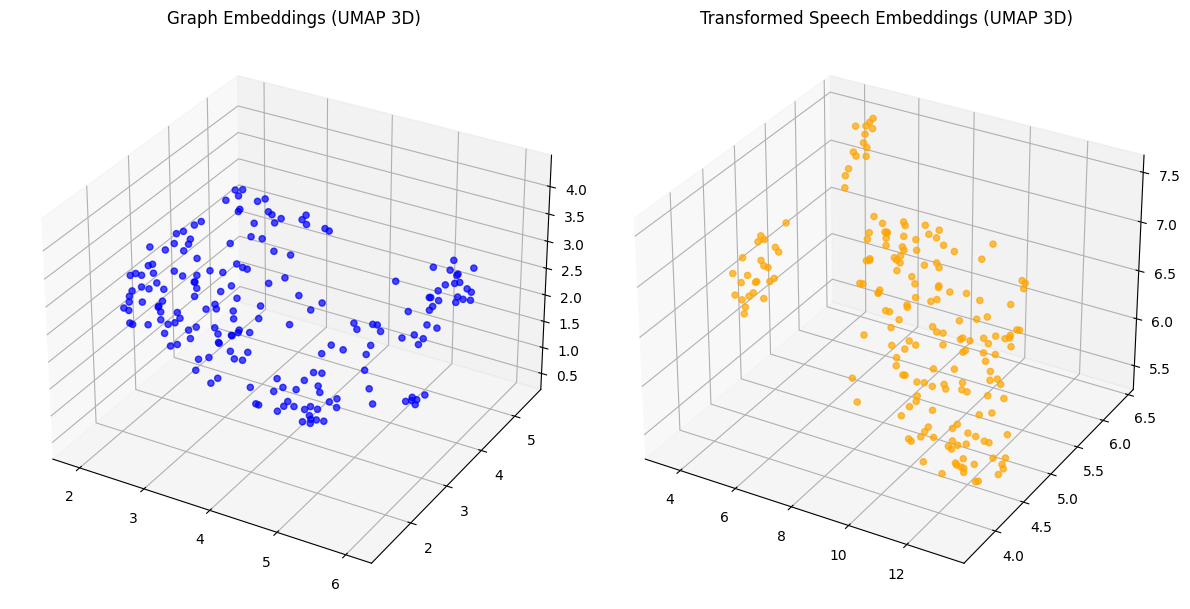

In [18]:
from mpl_toolkits.mplot3d import Axes3D

# Reduce to 3D for plotting
graph_umap_3d = umap.UMAP(n_components=3).fit_transform(graph_data)
transformed_3d = umap.UMAP(n_components=3).fit_transform(transformed_speech)

fig = plt.figure(figsize=(12, 6))

# --- Graph Embeddings ---
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title("Graph Embeddings (UMAP 3D)")
ax1.scatter(graph_umap_3d[:, 0], graph_umap_3d[:, 1], graph_umap_3d[:, 2], c='blue', alpha=0.7)

# --- Transformed Speech Embeddings ---
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Transformed Speech Embeddings (UMAP 3D)")
ax2.scatter(transformed_3d[:, 0], transformed_3d[:, 1], transformed_3d[:, 2], c='orange', alpha=0.7)

plt.tight_layout()
plt.show()

In [19]:
combined_embedding = torch.reshape(torch.tensor(transformed_speech), (4096, 190))

np_array = combined_embedding.detach().cpu().numpy()
final_country_embeddings = pd.DataFrame(np_array, columns=countries)
final_country_embeddings

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
0,-0.034409,0.005646,0.029713,0.075854,-0.046229,-0.079850,0.032920,-0.037552,-0.102229,0.079615,...,-0.073592,0.090817,-0.019056,0.042888,0.010282,0.019444,0.046927,-0.019244,0.047942,0.034078
1,0.068385,-0.000306,0.031482,0.112897,0.019995,-0.125677,0.000613,-0.076548,-0.098481,0.051539,...,0.004828,0.093049,-0.012054,0.002072,-0.027518,-0.003363,0.027313,0.095306,0.057457,0.017439
2,0.008381,0.022370,0.096784,0.019978,-0.079671,0.020160,0.006996,0.052844,-0.029781,0.009670,...,0.064746,-0.071594,-0.085277,-0.004495,0.028950,0.041932,0.104230,0.025319,0.014153,-0.077329
3,0.065139,-0.020570,0.018969,0.003303,-0.049298,-0.032197,0.085932,-0.011182,-0.077263,-0.006313,...,0.039764,0.017379,-0.027571,0.091579,-0.028877,0.000001,0.036607,-0.104798,-0.005132,-0.052857
4,0.026621,0.036927,0.050533,0.003183,0.006699,0.007556,0.119626,0.114894,0.070742,0.039515,...,0.005932,0.060689,-0.037920,0.002870,0.051526,-0.115202,0.077715,0.017853,-0.005529,0.070022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,0.070282,0.006240,-0.015627,0.034924,-0.043494,0.047023,0.086812,0.058066,-0.084160,0.126224,...,-0.049075,0.023111,0.005819,0.043606,-0.014096,-0.084388,-0.043685,0.004351,0.035388,0.031473
4092,0.041390,0.001705,0.000113,0.042999,-0.041678,-0.021276,0.071432,0.007528,-0.065376,0.028814,...,-0.004536,-0.016185,-0.018949,0.041645,-0.029424,0.087818,0.097195,0.048311,0.039729,-0.187265
4093,-0.134976,-0.013212,0.055331,-0.054306,0.031219,-0.080936,-0.082377,-0.102921,0.019507,0.021127,...,-0.014733,-0.019656,-0.044627,0.016726,0.021291,-0.056752,-0.007012,0.112284,-0.049590,-0.003337
4094,-0.044398,-0.113828,-0.041615,0.114148,-0.040626,-0.017833,0.098168,0.026640,0.195173,-0.079729,...,-0.025409,0.040250,0.003464,0.064260,0.031531,-0.048216,0.071929,0.020962,0.075656,0.041740


In [20]:
def compare_countries(country1, country2):
    cs = cosine_similarity(
        np.array(list(final_country_embeddings[country1])).reshape(1, -1),
        np.array(list(final_country_embeddings[country2])).reshape(1, -1)
    )
    return cs

(190, 128) (190, 4096)


Text(0.5, 1.0, 'Correlation Between Policy - Speech Embeddings')

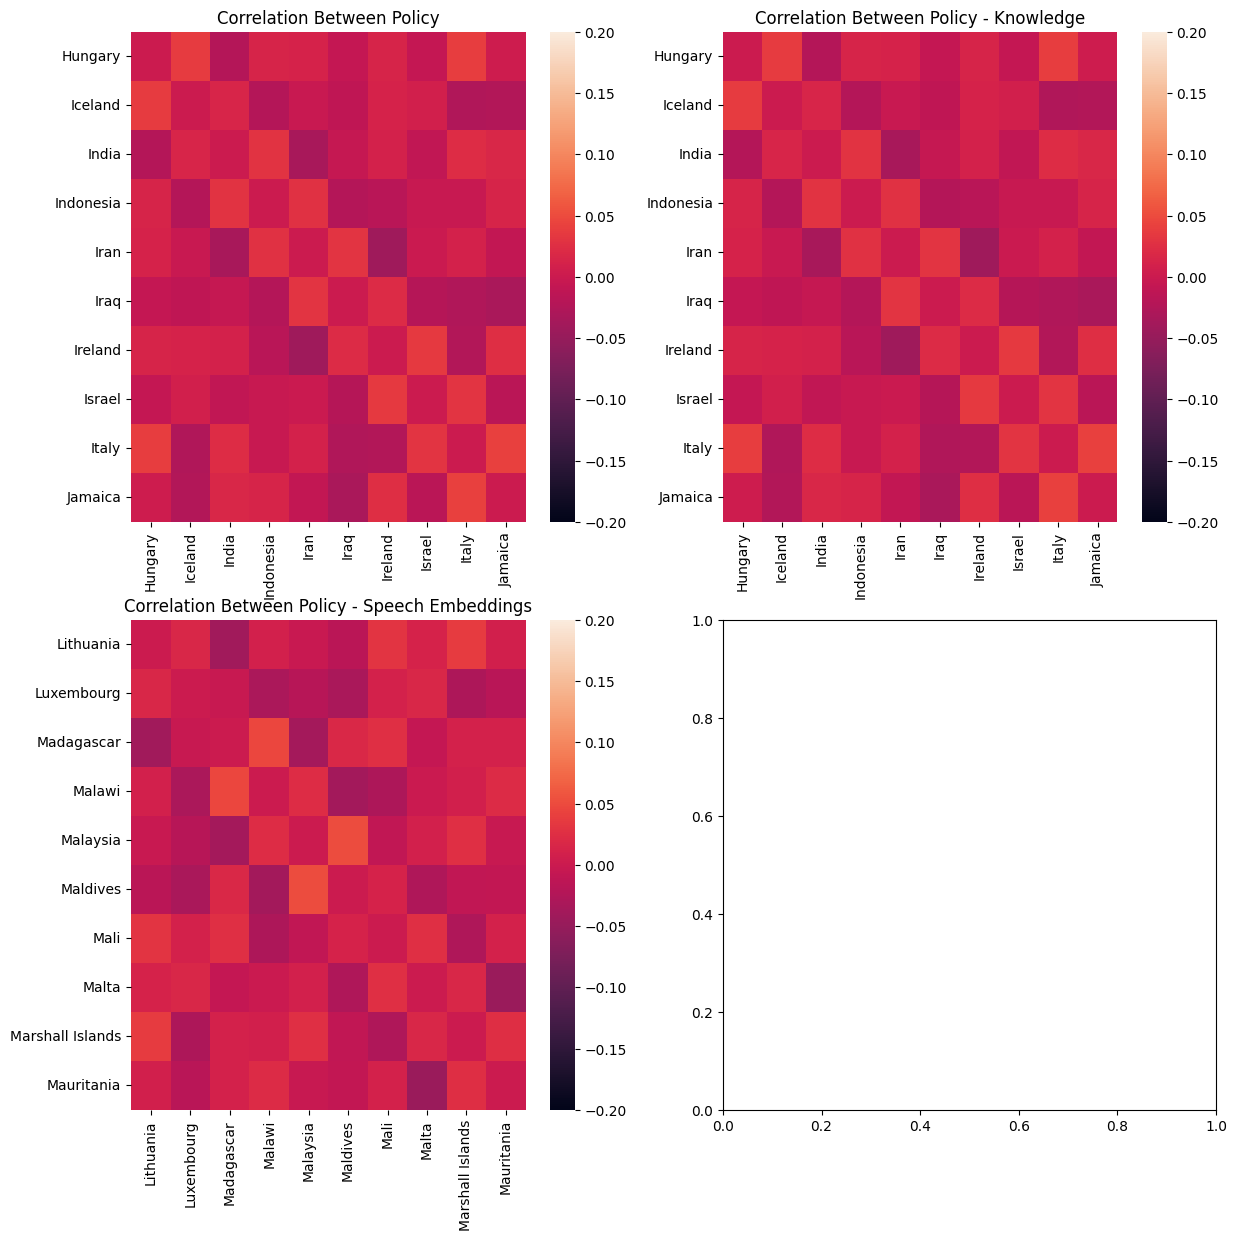

In [21]:
def get_corr_matrix(final_country_embeddings):
    start = random.randint(0, len(final_country_embeddings.columns)-10)
    corr_matrix = pd.DataFrame(
        index=final_country_embeddings.columns[start:start+10],
        columns=final_country_embeddings.columns[start:start+10],
        dtype=float
    )
    for i, country in enumerate(final_country_embeddings.columns[start:start+10]):
        for j, country_2 in enumerate(final_country_embeddings.columns[start:start+10]):
            if j > i:
                sim = compare_countries(country, country_2)
                corr_matrix.loc[country, country_2] = sim
                corr_matrix.loc[country_2, country] = sim
            elif j==i:
                corr_matrix.loc[country, country_2] = 0
    return corr_matrix

corr_matrix = get_corr_matrix(final_country_embeddings)
graph_data = np.array(graph_data)
speech_data = np.array(speech_data)
print(graph_data.shape, speech_data.shape)

graph_df = pd.DataFrame(graph_data.transpose(), columns=countries)
speech_df = pd.DataFrame(speech_data.transpose(), columns=countries)

graph_df = get_corr_matrix(graph_df)
speech_df = get_corr_matrix(speech_df)

fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

minmax = 0.2

sns.heatmap(corr_matrix, annot=False, vmin=-minmax, vmax=minmax, ax=axes[0])
axes[0].set_title('Correlation Between Policy')

sns.heatmap(graph_df, annot=False, vmin=-minmax, vmax=minmax, ax=axes[1])
axes[1].set_title('Correlation Between Policy - Knowledge')

sns.heatmap(speech_df, annot=False, vmin=-minmax, vmax=minmax, ax=axes[2])
axes[2].set_title('Correlation Between Policy - Speech Embeddings')

In [22]:
umap_model = umap.UMAP(n_components=5, random_state=42)
graph_umap = umap_model.fit_transform(graph_data)
speech_umap = umap_model.fit_transform(final_country_embeddings)

from scipy.spatial.distance import pdist, squareform

def get_distance_matrix(umap_embeddings, countries, sample_size=5):
    idx = sorted(random.sample(range(len(countries)), sample_size))
    selected = umap_embeddings[idx]
    dist_matrix = squareform(pdist(selected, metric='euclidean'))
    selected_countries = [countries[i] for i in idx]
    df = pd.DataFrame(dist_matrix, index=selected_countries, columns=selected_countries)
    return df

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Text(0.5, 1.0, 'UMAP Distance Between Country Policy Embeddings')

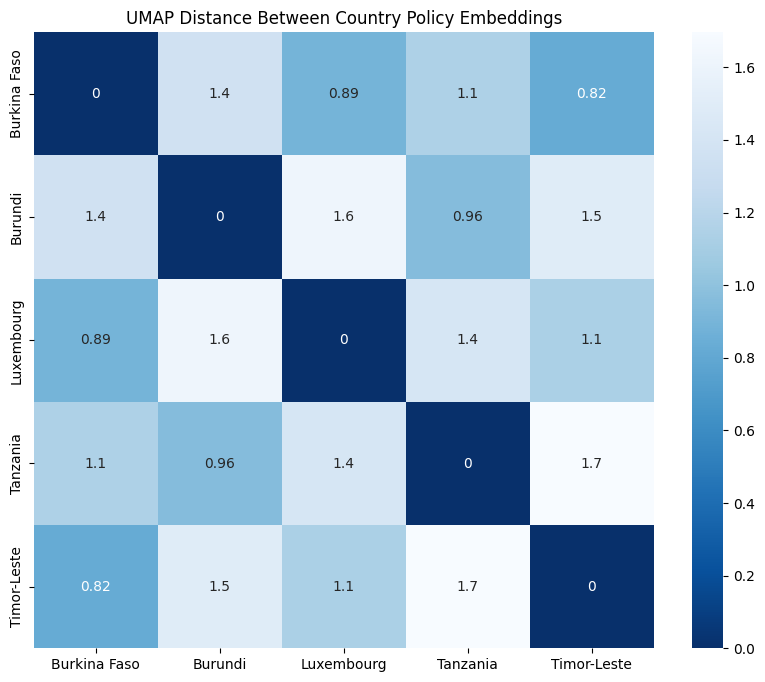

In [23]:
plt.figure(figsize=(10,8))

graph_umap_df = get_distance_matrix(graph_umap, countries, 5)
speech_umap_df = get_distance_matrix(speech_umap, countries, 5)

sns.heatmap(speech_umap_df, annot=True, vmin=0, vmax=None, cmap="Blues_r")
plt.title('UMAP Distance Between Country Policy Embeddings')

In [24]:
full_umap = get_distance_matrix(speech_umap, countries, 190)

In [25]:
from sklearn.metrics.pairwise import euclidean_distances
import umap
import math

umap_projector = umap.UMAP(n_components=2, random_state=42)

def generate_country_similarity(speech: str, place: str):
    clean_speech = clean_text(speech)
    speechs = get_segments(clean_speech)
    or_encode = np.array(generate_embeddings(speechs))
    av_vec = np.mean(or_encode, axis=0)

    av_vec = np.expand_dims(av_vec, axis=0)
    with torch.no_grad():
        av_vec = get_transformed_embeddings(trained_model, av_vec)

    country_names = list(final_country_embeddings.columns)
    country_matrix = np.stack([final_country_embeddings[col] for col in country_names])

    all_vectors = np.vstack([av_vec, country_matrix])

    all_umap = umap_projector.fit_transform(all_vectors)
    speech_vec = all_umap[0]
    country_vecs = all_umap[1:]

    dists = euclidean_distances([speech_vec], country_vecs)[0]

    lis = list(zip(dists, country_names))
    sorted_data = sorted(lis, key=lambda x: x[0]) 

    for dist, country in sorted_data:
        if country == place:
            print(f'\n\n-----{country}------\n\n')
            print(f"{-math.log(dist):.6f} — {country}")
            if -math.log(dist) > 0:
                print("You did a great job in policy alignment!!!")
        #else:
            #print(f"{-math.log(dist):.6f} — {country}")

In [26]:
def compute_closest_countries(country: str, num: int):
    distances = full_umap[country].copy()
    closest_countries = distances[distances > 0].nsmallest(num)
    print(f"3 closest countries to {country}: (UMAP Euclidian Distance)")
    print(closest_countries)
    print("\n\n")

In [27]:
MUN_speeches = pd.read_csv("/kaggle/input/mun-speech-dataset/MUN Speech Testing.csv")
index = random.randint(0, len(MUN_speeches)-1)
print(f"Policy similarities of speech:\n\n{MUN_speeches.loc[index]['Speech']} \n\nFrom delegate of nation: {MUN_speeches.loc[index]['Country']}\n\n")

print(f"{MUN_speeches.loc[index]['Country']} is part of the following organizations")
print("".join(f"   - {organization}\n" for organization in get_organizations(MUN_speeches.loc[index]['Country'])))

compute_closest_countries(MUN_speeches.loc[index]['Country'], 3)

generate_country_similarity(MUN_speeches.loc[index]['Speech'], MUN_speeches.loc[index]['Country'])

Policy similarities of speech:

The Amazon rainforest, Earth's green lung, is burning. The oil spill off Fukushima is a harsh reminder of the vulnerability of marine life. Being an island nation, Mauritius is all too aware of the unmitigated catastrophes that such disasters are capable of causing. In 2020 the MV Wakashio incident scarred the Mauritian shores which saw 1,000 tonnes of oil spilled into the ocean. In light of these challenges, Mauritius proposes the creation of SeaShield Network, an international rapid response mechanism for marine disasters, to coordinate efforts in addressing oil spills, radioactive contamination, and other marine emergencies. Additionally, Mauritius has implemented its Smart City Scheme and is committed to attaining 60% of its energy needs through green sources by 2030. Mauritius calls upon the developed nations to give all possible help that will enable small island developing states to implement green urban planning initiatives. Let us join together 

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Generating embeddings with BAAI/bge-large-en-v1.5 and text-embedding-3-large:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings with BAAI/bge-large-en-v1.5 and text-embedding-3-large:  25%|██▌       | 1/4 [00:01<00:05,  1.68s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings with BAAI/bge-large-en-v1.5 and text-embedding-3-large:  50%|█████     | 2/4 [00:02<00:02,  1.31s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings with BAAI/bge-large-en-v1.5 and text-embedding-3-large:  75%|███████▌  | 3/4 [00:04<00:01,  1.35s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings with BAAI/bge-large-en-v1.5 and text-embedding-3-large: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(




-----Mauritius------


-0.195829 — Mauritius
